# Customer behavior and segmentation from OLIST database

### 1. Connect to the SQLite DataBased

In [300]:
import sqlite3 #library untuk menghubungkan sql dengan phyton

In [301]:
conn = sqlite3.connect("foo.db") # Membuat/mengakses database sql dengan phyton

### 2. Import library

In [302]:
#Import Library yang diperlukan dalam proses analisis dan visualisasi

import pandas as pd #library untuk manipulasi dan analisis data.
import matplotlib.pyplot as plt #library untuk visualisasi data.
import seaborn as sns #library visualisasi data berbasis Matplotlib yang lebih modern.
import numpy as np  #library untuk komputasi numerik.
from datetime import datetime #modul bawaan Python untuk manipulasi waktu dan tanggal.

### 3. Combining Tables/Menggabungkan Tabel

In [303]:
# mengimput query SQL yang memuat kolom yang di butuhkan dari setiap tabel yang tersedia dan\
# menggabungkan masing-masing tabel yang saling berhubungan dengan koneksi kunci berdasarkan kerangka kerja dataset.
''' mengambil semua kolom dari tabel order,
mengambil kolom price dan freight value pada kolom order_item,
mengambil kolom payment value dan payment score dari tabel order_payment,
mengambil kolom review_score, review_comment_title, dan review_comment_message dari kolom order_reviews,
mengambil product_weight_g, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty dari tabel products.

kemudian, menggabungkan maing-masing tabel dengan menggunakan keyy sebagai kunci koneksi antar tabel.
'''
#membuat variabel bernama "query" yang memuat query SQL.
query = """
SELECT o.*, 
       c.customer_unique_id,
       c.customer_city AS address_city,
       c.customer_state AS address_static,
       i.price AS product_price,
       i.freight_value AS shipping_price,
       p.payment_value,
       p.payment_type,
       r.review_score,
       r.review_comment_title,
       r.review_comment_message,
       pr.product_weight_g AS product_weight,
       pr.product_category_name,
       pr.product_name_lenght,
       pr.product_description_lenght,
       pr.product_photos_qty
FROM olist_orders_dataset o
JOIN olist_customers_dataset c ON o.customer_id = c.customer_id
LEFT JOIN olist_order_items_dataset i ON o.order_id = i.order_id
LEFT JOIN olist_order_payments_dataset p ON o.order_id = p.order_id
LEFT JOIN olist_order_reviews_dataset r ON o.order_id = r.order_id
LEFT JOIN olist_products_dataset pr ON i.product_id = pr.product_id
WHERE o.order_status = 'delivered'
"""

df = pd.read_sql(query, conn) #menggunakan library Pandas untuk membaca data dari database SQL ke dalam sebuah DataFrame.

In [304]:
print(df.head())

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49  2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10

In [305]:
print(df.dtypes) #perintah dalam Pandas untuk mengecek tipe data (data types) dari setiap kolom dalam DataFrame (df).

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
customer_unique_id               object
address_city                     object
address_static                   object
product_price                    object
shipping_price                   object
payment_value                    object
payment_type                     object
review_score                     object
review_comment_title             object
review_comment_message           object
product_weight                   object
product_category_name            object
product_name_lenght              object
product_description_lenght       object
product_photos_qty               object
dtype: object


In [306]:
# merubah tipe data agar sesuai dengan tipe data yang diinginkan
# 1.Konversi kolom datetime. merubah tipe data object ke tipe datetime
datetime_cols = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
]
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')


# 2. Konversi kolom price menjadi numerik. merubah tipe data object ketipe numerik (float)
numeric_cols = ['product_price', 'shipping_price', 'payment_value', 'review_score']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Ubah tipe data kolom dimensi menjadi numerik 
cols_to_convert = ['product_weight', 'product_name_lenght', 
                  'product_description_lenght', 'product_photos_qty']
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [307]:
print(df.dtypes)

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
customer_unique_id                       object
address_city                             object
address_static                           object
product_price                           float64
shipping_price                          float64
payment_value                           float64
payment_type                             object
review_score                            float64
review_comment_title                     object
review_comment_message                   object
product_weight                          float64
product_category_name                    object
product_name_lenght                     

### 4. Handling Missing Values

In [308]:
# Identifikasi nilai null
null_counts = df.isnull().sum()
print("Jumlah nilai null per kolom:")
print(null_counts[null_counts > 0])

Jumlah nilai null per kolom:
order_approved_at                  15
order_delivered_carrier_date        2
order_delivered_customer_date       8
payment_value                       3
payment_type                        3
review_score                      861
review_comment_title              861
review_comment_message            861
product_weight                     20
product_name_lenght              1638
product_description_lenght       1638
product_photos_qty               1638
dtype: int64


In [309]:
# 1. Tanggal persetujuan order: kemungkinan besar pesanan di-approve otomatis atau tidak dicatat, bisa isi dengan tanggal pembelian/order
df['order_approved_at'] = df['order_approved_at'].fillna(df['order_purchase_timestamp'])

# 2. Tanggal dikirim ke kurir: jika null, kemungkinan pengiriman belum dilakukan, bisa diisi dengan median (lebih netral)
# median lebih stabil karena mengambil nilai tengah.
df['order_delivered_carrier_date'] = df['order_delivered_carrier_date'].fillna(df['order_delivered_carrier_date'].median())

# 3. Tanggal diterima pelanggan: bisa juga isi median atau hapus baris jika hanya 8 nilai
df['order_delivered_customer_date'] = df['order_delivered_customer_date'].fillna(df['order_delivered_customer_date'].median())

# 4. payment_value: jika kosong padahal sudah delivered, kemungkinan masalah data. Bisa isi dengan median
# median (nilai tengah) lebih stabil terhadap pengaruh outlier. membuat hasil analisis jadi lebih representatif

df['payment_value'] = df['payment_value'].fillna(df['payment_value'].median())

# 5. payment_type : kolom ini  adalah data kategorikal, unknown digunakan untuk mengisi null agar Mencegah hilangnya data dan tidak bias.
df['payment_type'] = df['payment_type'].fillna('unknown')

# 6. review_score: tidak semua pelanggan memberikan reviws score, kita bisa menganggap tidak mengisi review = netral (skor 3)
df['review_score'] = df['review_score'].fillna(3)

# 7. review_comment_title:  kolom ini  adalah data kategorikal, no title digunakan untuk mengisi null agar Mencegah hilangnya data dan tidak bias.  
df['review_comment_title'] = df['review_comment_title'].fillna('No Title')

# 8. review_comment_message:  kolom ini  adalah data kategorikal, no message digunakan untuk mengisi null agar Mencegah hilangnya data dan tidak bias.
df['review_comment_message'] = df['review_comment_message'].fillna('No Message')

# 9. Tangani nilai null pada berat dan dimensi produk
# Kolom bertipe numerik kontinu, sehingga kita menggunakan median (nilai tengah). karena untuk Menghindari bias akibat outlier dan penghapusan baris.
df['product_weight'] = df['product_weight'].fillna(df['product_weight'].median())
df['product_name_lenght'] = df['product_name_lenght'].fillna(df['product_name_lenght'].median())
df['product_description_lenght'] = df['product_description_lenght'].fillna(df['product_description_lenght'].median())

# 10. product_photos_qty : kemungkinan besar null disebabkan tidak ada foto, mengisi baris null dengan nilai 0, Menjaga data tetap utuh tanpa menghapus baris
df['product_photos_qty'] = df['product_photos_qty'].fillna(0)


In [310]:
# Identifikasi kembai nilai null
null_counts = df.isnull().sum()
print("Jumlah nilai null per kolom:")
print(null_counts[null_counts > 0])

Jumlah nilai null per kolom:
Series([], dtype: int64)


### Data Overview

In [311]:
# mengecek tanggal awal, tanggal akhir, dan durasi
start_date = df['order_purchase_timestamp'].min() # tanggal awal
end_date = df['order_purchase_timestamp'].max() # tanggal akhir
duration_days = (end_date - start_date).days # Durasi waktu

print(f"Tanggal awal  : {start_date.date()}")
print(f"Tanggal akhir : {end_date.date()}")
print(f"Durasi data   : {duration_days} hari")

Tanggal awal  : 2016-09-15
Tanggal akhir : 2018-08-29
Durasi data   : 713 hari


In [312]:
# Menghitung jumlah pesanan
total_orders = df['order_id'].nunique()

# Menghitung jumlah pelanggan unik
total_customers = df['customer_id'].nunique()

# Menghitung jumlah kategori produk unik
total_categories = df['product_category_name'].nunique()

print(f"Jumlah pesanan         : {total_orders}")
print(f"Jumlah pelanggan unik  : {total_customers}")
print(f"Jumlah kategori produk : {total_categories}")

Jumlah pesanan         : 96478
Jumlah pelanggan unik  : 96478
Jumlah kategori produk : 74


### 5. Menambahkan kolom

In [313]:
# 1.Tambahkan kolom waktu
df['tahun'] = df['order_purchase_timestamp'].dt.year #menambahkan kolom tahun
df['bulan'] = df['order_purchase_timestamp'].dt.month #menambahkan kolom bulan
df['nama_hari'] = df['order_purchase_timestamp'].dt.day_name() #menambahkan kolom nama_hari
df['jam'] = df['order_purchase_timestamp'].dt.hour #menambahkan kolom hari

In [314]:
# 2.Tambahkan kolom total nilai belanja
# Hitung total nilai belanja per order
agg_df = df.groupby('order_id', as_index=False).agg({
    'product_price': 'sum',  # Harga barang–dijumlahkan untuk semua item dalam pesanan.
    'shipping_price': 'sum', # Biaya kirim dari masing-masing item.
}).rename(columns={
    'product_price': 'total_product_price', # mengganti nama product_price menjadi total_product_price
    'shipping_price': 'total_shipping_cost', # mengganti nama shipping_price menjadi total_shipping_cost
})

# Gabungkan ke dataframe utama
df = df.drop(columns=['total_product_price', 'total_shipping_cost'], errors='ignore') #memastikan kolom total_product_price dan total_shipping_cost tidak terduplikasi.
df = df.merge(agg_df, on='order_id', how='left') # menggabungakan hasil aggreasi kedalam data utama

# Hitung total order value dari price + shipping
df['total_order_value'] = df['total_product_price'] + df['total_shipping_cost'] # menghitung nilai aktual yang dibayar oleh pelanggan.

print(df.head(2))

                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   

  order_estimated_delivery_date                customer_unique_id  \
0                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   
1                    2017-10-18  7c396fd4830fd04220f754e42b4e5bff   

  address_city  ... product_name_lenght  product_description_lenght  \
0    sao paulo  ...                40.0                       268.0   
1    sao paulo  ...                40.0        

### Customer Demographic

#### 6.1 Customer Demographic (state)

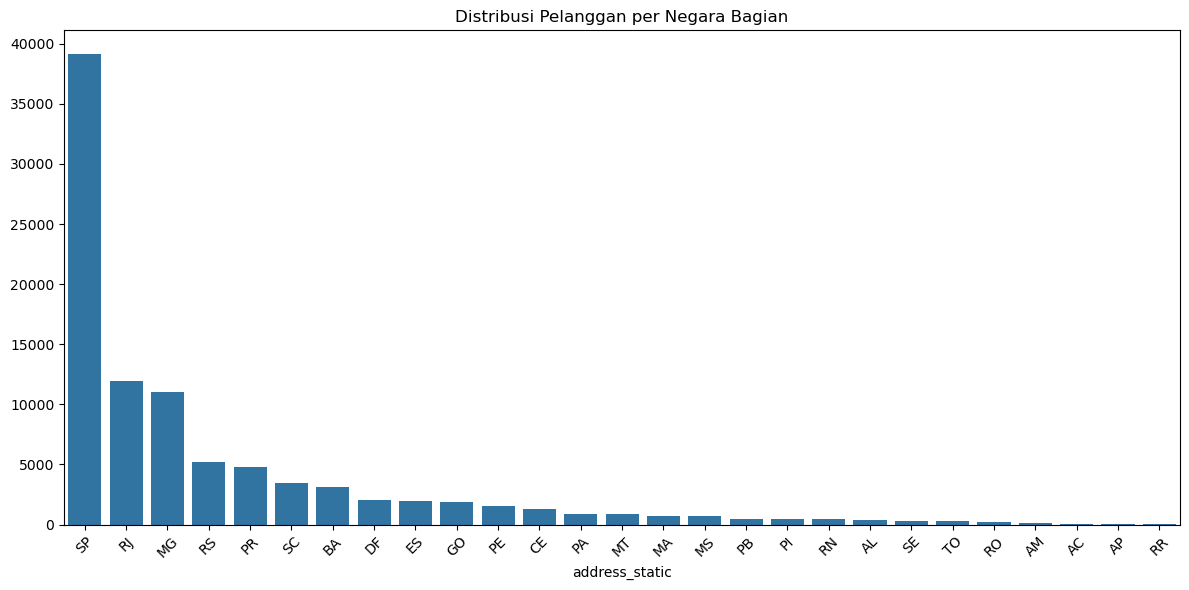

In [315]:
# Mengelompokkan data berdasarkan address_static untuk Menghitung jumlah pelanggan unik
# serta mengurutkan data dari yang terbesar
state_counts = df.groupby('address_static')['customer_unique_id'].nunique().sort_values(ascending=False)

# Visualisasi pelanggan per negara bagian
plt.figure(figsize=(12,6)) # ukuran grafik
sns.barplot(x=state_counts.index, y=state_counts.values)  # menentukan index dan value
plt.title('Distribusi Pelanggan per Negara Bagian') # menambahkan judul
plt.xticks(rotation=45) # menentukan besaran rotasi nama variabel x 
plt.tight_layout() # menyesuaikan jarak (padding) antara subplot dan elemen-elemen gambar
plt.savefig('dis negara bagian.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show() # menunjukan hasil

#### 6.2 Customer Demographic (city)

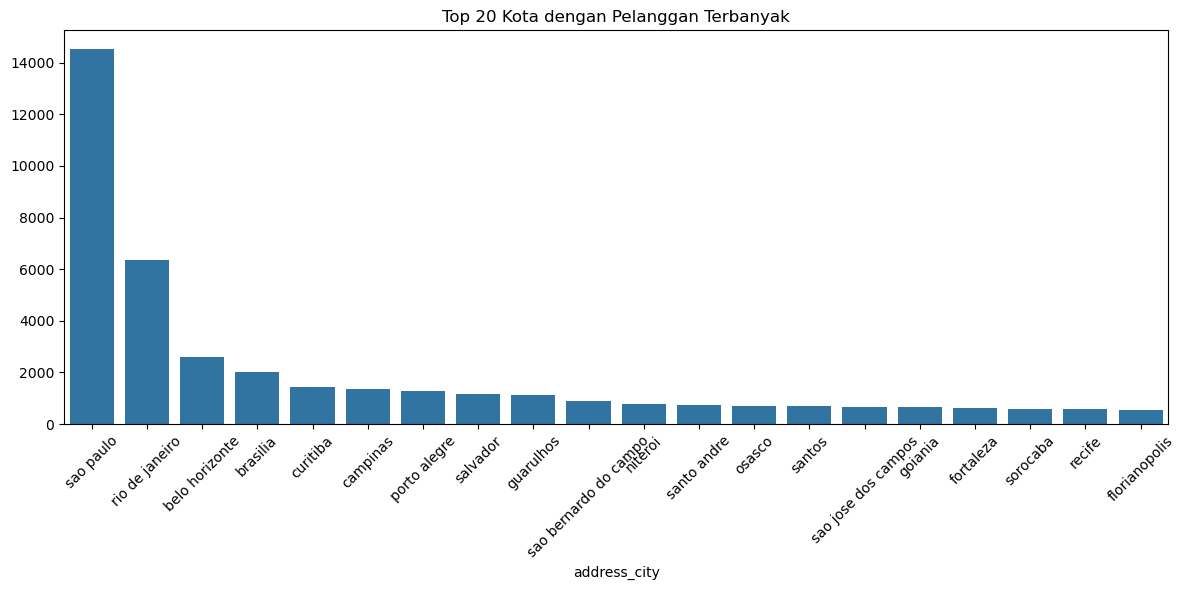

In [316]:
# Visualisasi pelanggan per kota (top 20)
city_counts = df.groupby('address_city')['customer_unique_id'].nunique().sort_values(ascending=False).head(20)

# Visualisasi pelanggan per kota
plt.figure(figsize=(12,6))  #ukuran grafik 
sns.barplot(x=city_counts.index, y=city_counts.values) # menentukan index dan value
plt.title('Top 20 Kota dengan Pelanggan Terbanyak') # menambahkan judul
plt.xticks(rotation=45)  # menentukan besaran rotasi nama variabel x
plt.tight_layout() # menyesuaikan jarak (padding) antara subplot dan elemen-elemen gambar
plt.savefig('dis kota.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show() # menunjukan hasil

### 6.3 Frekuensi Pesanan

In [317]:
# menghitung frekuensi pesanan per pelanggan
order_freq = df.groupby('customer_unique_id')['order_id'].nunique().reset_index() # Menghitung Frekuensi Pesanan per Pelanggan
order_freq = order_freq.rename(columns={'order_id': 'total_orders'}) # Mengubah Nama Kolom

# Tambahkan kolom kategori frekuensi
order_freq['kategori_frekuensi'] = order_freq['total_orders'].apply(
    lambda x: 'sedikit' if x <= 5 else 'banyak'
) # mengkategorikan pelanggan berdasarkan jumlah pesanan

# Menampilkan hasil
print("Frekuensi Pesanan per Pelanggan:")
print(order_freq.head(5)) 

Frekuensi Pesanan per Pelanggan:
                 customer_unique_id  total_orders kategori_frekuensi
0  0000366f3b9a7992bf8c76cfdf3221e2             1            sedikit
1  0000b849f77a49e4a4ce2b2a4ca5be3f             1            sedikit
2  0000f46a3911fa3c0805444483337064             1            sedikit
3  0000f6ccb0745a6a4b88665a16c9f078             1            sedikit
4  0004aac84e0df4da2b147fca70cf8255             1            sedikit


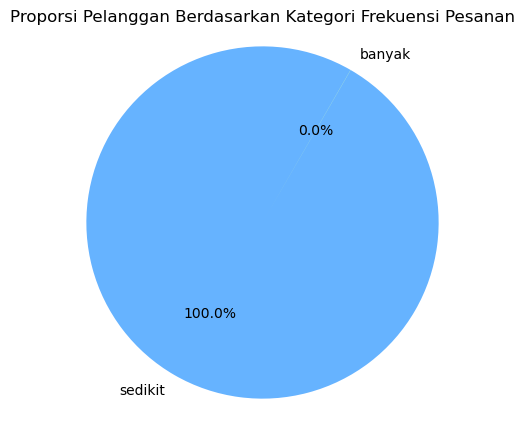

In [318]:
# membuat plot Pelanggan Berdasarkan Kategori Frekuensi Pesanan
category_counts = order_freq['kategori_frekuensi'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', 
        startangle=60, colors=['#66b3ff','#99ff99'])
plt.title('Proporsi Pelanggan Berdasarkan Kategori Frekuensi Pesanan')
plt.axis('equal')  # pie chart berbentuk lingkaran
plt.savefig('proporsi.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show()

In [319]:
# hasil analisis menunjukan bahwa semua pelangan hanya melakukan 1 kali order sehingga masuk dalam kategori sedikit

#### 6.4 Selisih pembelian pertama, pembelian terakhir, dan total pesanan per customer

In [320]:
# Hitung pembelian pertama, pembelian terakhir, dan total pesanan per customer
purchase_stats = df.groupby('customer_id').agg(
    first_purchase=('order_purchase_timestamp', 'min'),
    last_purchase=('order_purchase_timestamp', 'max'),
    total_orders=('order_id', 'nunique')
).reset_index()

# Hitung selisih hari antara pembelian terakhir dan pertama
purchase_stats['days_between'] = (purchase_stats['last_purchase'] - purchase_stats['first_purchase']).dt.days

# mengurutkan pelanggan dari yang paling lama
purchase_stats = purchase_stats.sort_values(by='days_between', ascending=False)

# Lihat hasilnya
print(purchase_stats.head(5))

                            customer_id      first_purchase  \
0      00012a2ce6f8dcda20d059ce98491703 2017-11-14 16:08:26   
64315  aa5e0a0c36015d39de864189a2b00b09 2018-08-14 19:44:14   
64324  aa6190994371836fc1d4596edd827abd 2017-12-28 21:21:58   
64323  aa606152f23a5fa9ba3d0b87f7a492e8 2018-01-16 23:18:27   
64322  aa601b3c45980c0918042d5ca7a25054 2018-03-15 16:59:11   

            last_purchase  total_orders  days_between  
0     2017-11-14 16:08:26             1             0  
64315 2018-08-14 19:44:14             1             0  
64324 2017-12-28 21:21:58             1             0  
64323 2018-01-16 23:18:27             1             0  
64322 2018-03-15 16:59:11             1             0  


#### Kesimpulan

#####  1. Dari data jumlah pelanggan per state, terlihat bahwa mayoritas pelanggan berasal dari wilayah Kota SP dengan jumlah pelanggan lebih dari 35.000 pelanggan, diikuti kota RJ, selanjutnya kota MG dan seterusnya adalah pasar utama yang harus menjadi fokus distribusi, promosi, dan stok barang.
##### 2. Dari data jumlah pelanggan per city, terlihat bahwa wilayah dengan total total pelanggan terbanyak adalah kota sau paulo dengan jumlah pelanggan lebih dari 14.000, diikuti rio de janerio, selanjutnya belo horizonte dan seterusnya adalah pasar utama yang harus menjadi fokus distribusi, promosi, dan stok barang.
##### 3. Semua Pelanggan Masuk ke dalam kategori sedikit pada frekuensi order. itu artinya semua pelanggan melakakukan total order kurang dari 5 kali.

### 7. Perilaku Pesanan

##### 7.1. Rata-rata jumlah barang

In [321]:
# Menghitung Jumlah Barang per Pelanggan
item_count = df.groupby('customer_unique_id')['order_id'].count().reset_index(name='total_items')

# Membuat Kategori Frekuensi Pembelian
item_count['frekuensi'] = item_count['total_items'].apply(lambda x: 'sedikit' if x <= 5 else 'banyak')

print (item_count.head(5)) # menampilkan hasil

                 customer_unique_id  total_items frekuensi
0  0000366f3b9a7992bf8c76cfdf3221e2            1   sedikit
1  0000b849f77a49e4a4ce2b2a4ca5be3f            1   sedikit
2  0000f46a3911fa3c0805444483337064            1   sedikit
3  0000f6ccb0745a6a4b88665a16c9f078            1   sedikit
4  0004aac84e0df4da2b147fca70cf8255            1   sedikit


#### 7.2. Berat dan simpangan baku Rata-rata

In [322]:
# Buat tabel pengelompokan rata-rata dan std berat barang per kategori produk
berat_statistik = df.groupby('product_category_name')['product_weight'].agg(['mean', 'std']).reset_index()

# Ganti nama kolom
berat_statistik.rename(columns={
    'mean': 'rata_rata_berat',
    'std': 'simpangan_baku_berat'
}, inplace=True)

# Tampilkan hasil
berat_statistik.sort_values(by='rata_rata_berat', ascending=False).head(10).reset_index()

,index,product_category_name,rata_rata_berat,simpangan_baku_berat
0,56,moveis_escritorio,11248.990357,4797.039808
1,57,moveis_quarto,10319.957983,5177.439018
2,30,eletrodomesticos_2,9887.965779,7124.575148
3,54,moveis_cozinha_area_de_servico_jantar_e_jardim,8772.082474,8146.842160
4,53,moveis_colchao_e_estofado,8388.750000,10823.369111
5,58,moveis_sala,8145.227099,6161.897734
6,62,pcs,6946.111111,5459.893232
7,44,industria_comercio_e_negocios,6603.565056,5765.818870
8,51,malas_acessorios,5729.243902,7538.290409
9,65,portateis_casa_forno_e_cafe,5118.560000,4420.855791


#### 7.3 Waktu pemesanan paling sering 

In [323]:
# Tambahkan kategori waktu berdasarkan jam
def kategori_waktu(jam):
    if 5 <= jam < 12:
        return 'pagi'
    elif 12 <= jam < 18:
        return 'siang'
    else:
        return 'malam'

# Kolom waktu_pemesanan
df['waktu_pemesanan'] = df['jam'].apply(kategori_waktu)

# Tabel pengelompokan jumlah order berdasarkan bulan, hari, dan waktu
waktu_order_df = df.groupby(['bulan', 'nama_hari', 'jam', 'waktu_pemesanan'])['order_id'].count().reset_index(name='jumlah_order')

# Urutkan untuk melihat waktu terbanyak
waktu_order_df = waktu_order_df.sort_values(by='jumlah_order', ascending=False)

# Tampilkan hasil
print(waktu_order_df.head(5))

      bulan nama_hari  jam waktu_pemesanan  jumlah_order
1271      8  Thursday   12           siang           222
1303      8   Tuesday   20           malam           202
775       5  Thursday   16           siang           190
441       3  Thursday   16           siang           180
1035      7    Monday   16           siang           177


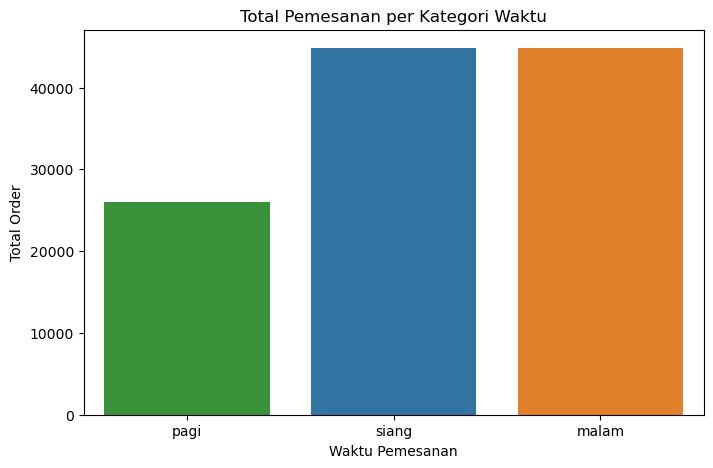

In [324]:
# membuat plot untuk membandingkan total pesanan per kategori waktu.
plt.figure(figsize=(8, 5))
sns.barplot(
    data=waktu_order_df, 
    x='waktu_pemesanan', 
    y='jumlah_order',
    hue='waktu_pemesanan',
    estimator=sum, 
    errorbar=None, 
    order=['pagi', 'siang', 'malam'],
    legend=False 
)

plt.title('Total Pemesanan per Kategori Waktu')
plt.xlabel('Waktu Pemesanan')
plt.ylabel('Total Order')
plt.savefig('kategori waktu.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show()

In [325]:
# Hitung total order per kategori waktu
total_per_waktu = waktu_order_df.groupby('waktu_pemesanan')['jumlah_order'].sum().reset_index()
total_per_waktu = total_per_waktu.sort_values('jumlah_order', ascending=False)

print("Total Pemesanan per Kategori Waktu:")
print(total_per_waktu.to_string(index=False))

Total Pemesanan per Kategori Waktu:
waktu_pemesanan  jumlah_order
          malam         44833
          siang         44825
           pagi         26065


In [326]:
# berdasarkan analisis. mayoritas melakukan akitivitas pembelianpada siang hari 

#### 7.4 Klasifikasi nilai pesanan

In [327]:
# Tambahkan kategori berdasarkan harga
# Mengambil kolom avg_order_value dan menerapkan fungsi kategori_harga pada setiap nilainya.
# Hasil dari operasi apply akan disimpan dalam kolom baru bernama kategori_harga di DataFrame order_avg.

order_avg = df.groupby('customer_unique_id')['total_order_value'].mean().reset_index(name='avg_order_value')
def kategori_harga(x):
    if x > 2500:
        return 'mahal'
    elif x >= 1000:
        return 'normal'
    else:
        return 'murah'
order_avg['kategori_harga'] = order_avg['avg_order_value'].apply(kategori_harga)

# menampilkan hasil
print(order_avg.head(10))


                 customer_unique_id  avg_order_value kategori_harga
0  0000366f3b9a7992bf8c76cfdf3221e2           141.90          murah
1  0000b849f77a49e4a4ce2b2a4ca5be3f            27.19          murah
2  0000f46a3911fa3c0805444483337064            86.22          murah
3  0000f6ccb0745a6a4b88665a16c9f078            43.62          murah
4  0004aac84e0df4da2b147fca70cf8255           196.89          murah
5  0004bd2a26a76fe21f786e4fbd80607f           166.98          murah
6  00050ab1314c0e55a6ca13cf7181fecf            35.38          murah
7  00053a61a98854899e70ed204dd4bafe           419.18          murah
8  0005e1862207bf6ccc02e4228effd9a0           150.12          murah
9  0005ef4cd20d2893f0d9fbd94d3c0d97           129.76          murah


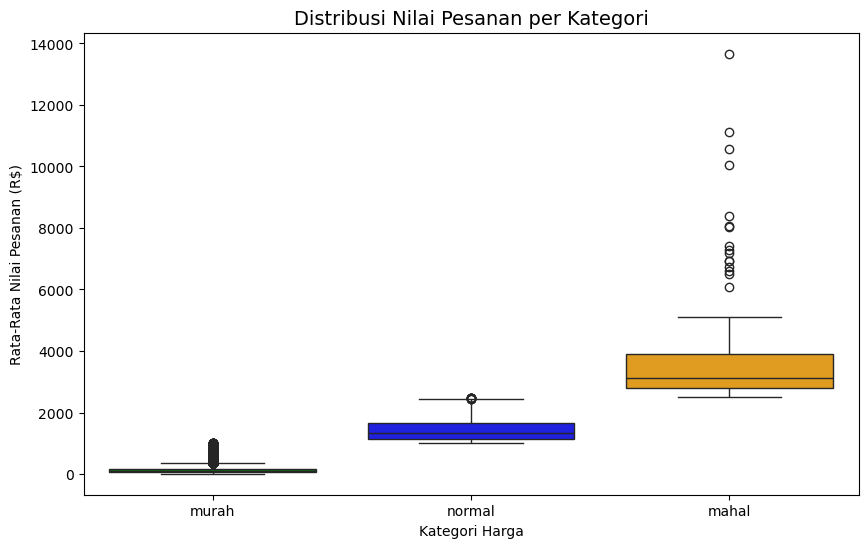

In [328]:
# Plot boxplot Nilai Pesanan per Kategori
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=order_avg, #mengamil data ari order_avg
    x='kategori_harga', 
    y='avg_order_value', 
    hue='kategori_harga',
    palette={'murah': 'green', 'normal': 'blue', 'mahal': 'orange'}, #pemilihan warna
    order=['murah', 'normal', 'mahal'], #kategori nilai
    legend=False #Legenda adalah kotak kecil di dalam/samping plot
)
plt.title('Distribusi Nilai Pesanan per Kategori', fontsize=14)
plt.xlabel('Kategori Harga')
plt.ylabel('Rata-Rata Nilai Pesanan (R$)')
plt.savefig('nilai pesanan per kategori.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show()

In [329]:
# berdasarkan hasil analisis, mayoritas pelanggan untuk rata-rata order value nya masuk ke dalam kategori murah.
# artinya mayoritas pelanggan nilai dari order/pembeliaan dibawah 1000

#### 7.5 Metode Pembayaran Populer

In [330]:
# Metode pembayaran dan produk favorit
fav_payment = df.groupby(['customer_unique_id', 'payment_type']).size().reset_index(name='total')
fav_payment = fav_payment.sort_values(['customer_unique_id','total'], ascending=[True, False])
fav_payment = fav_payment.drop_duplicates('customer_unique_id')

print(fav_payment.head(10))

                 customer_unique_id payment_type  total
0  0000366f3b9a7992bf8c76cfdf3221e2  credit_card      1
1  0000b849f77a49e4a4ce2b2a4ca5be3f  credit_card      1
2  0000f46a3911fa3c0805444483337064  credit_card      1
3  0000f6ccb0745a6a4b88665a16c9f078  credit_card      1
4  0004aac84e0df4da2b147fca70cf8255  credit_card      1
5  0004bd2a26a76fe21f786e4fbd80607f  credit_card      1
6  00050ab1314c0e55a6ca13cf7181fecf       boleto      1
7  00053a61a98854899e70ed204dd4bafe  credit_card      2
8  0005e1862207bf6ccc02e4228effd9a0  credit_card      1
9  0005ef4cd20d2893f0d9fbd94d3c0d97  credit_card      1


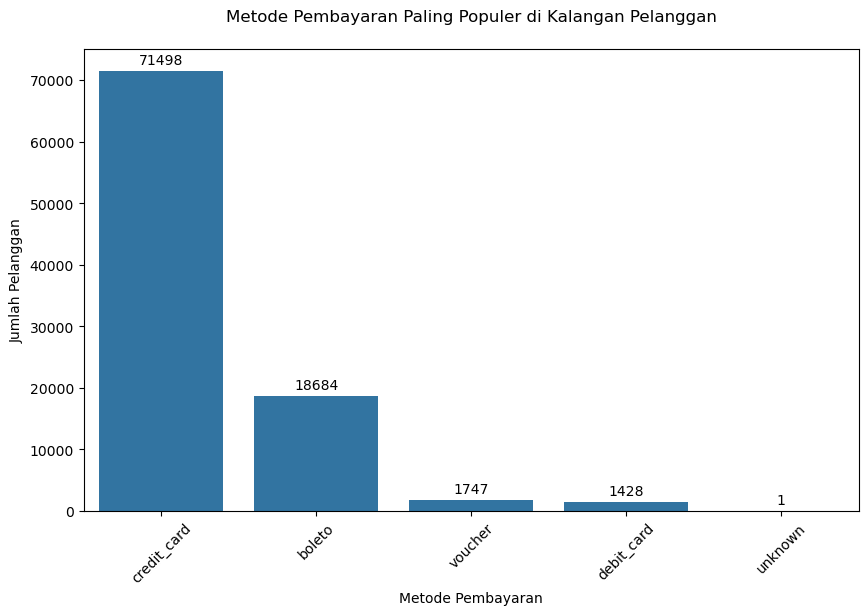

In [331]:
# Menampilkan distribusi metode pembayaran yang paling banyak dipilih pelanggan.
plt.figure(figsize=(10, 6))
sns.countplot(
    data=fav_payment,
    x='payment_type',
    order=fav_payment['payment_type'].value_counts().index,
)
plt.title('Metode Pembayaran Paling Populer di Kalangan Pelanggan', pad=20)
plt.xlabel('Metode Pembayaran')
plt.ylabel('Jumlah Pelanggan')
plt.xticks(rotation=45)

# Tambahkan label jumlah di atas setiap bar
for p in plt.gca().patches:
    plt.gca().annotate(
        f'{int(p.get_height())}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 8),
        textcoords='offset points'
    )
plt.savefig('metode pembayaran.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show()

In [332]:
# berasarkan analisis. diketahui bahwa mayoritas pelanggan melakukan pembayaran dengan metode credit_card

### 7.6 Kategori produk populer per wilayah

##### Mencari Kategori produk populer per wilayah (address_static)

In [333]:
popular_category_per_state = (
    df.groupby(['address_static', 'product_category_name'])
      .agg(total_orders=('order_id', 'nunique'))
      .reset_index()
)
# Urutkan berdasarkan wilayah lalu total_orders (dari besar ke kecil)
popular_category_per_state = popular_category_per_state.sort_values(
    ['address_static', 'total_orders'], 
    ascending=[True, False])
    
# Ambil hanya 1 produk terpopuler per wilayah
popular_category_top1 = popular_category_per_state.drop_duplicates(
    subset=['address_static'], keep='first'
)
print (popular_category_per_state.head(5))

   address_static   product_category_name  total_orders
11             AC           esporte_lazer             9
20             AC        moveis_decoracao             7
4              AC            beleza_saude             6
15             AC  informatica_acessorios             6
26             AC               telefonia             5


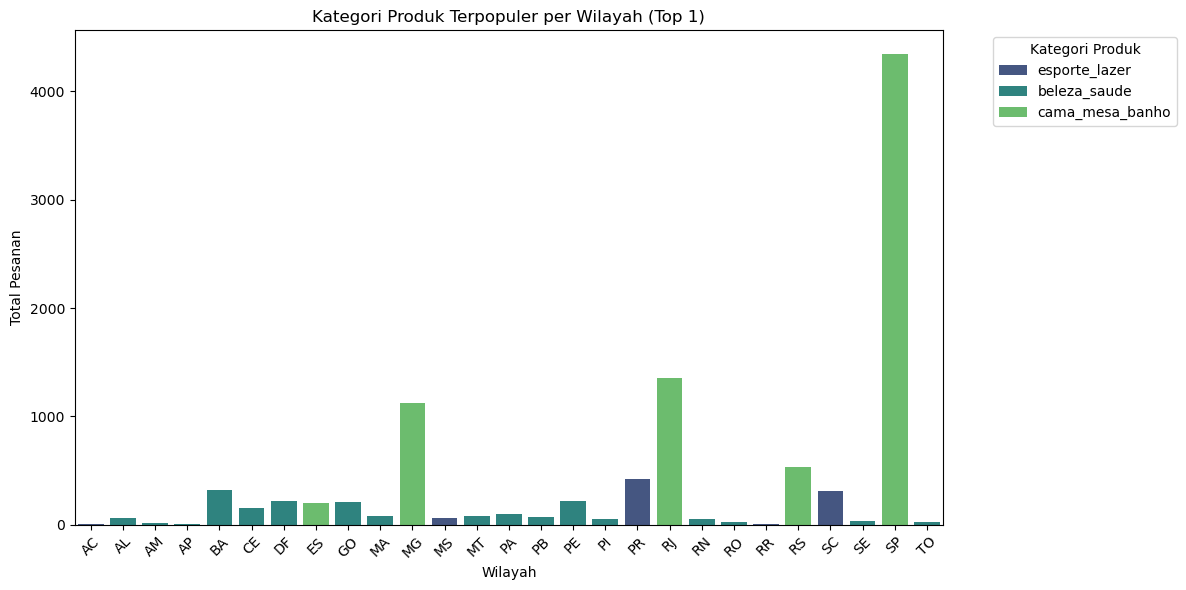

In [334]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=popular_category_top1,
    x='address_static', 
    y='total_orders', 
    hue='product_category_name',  # Warna berbeda untuk setiap kategori
    palette='viridis',
    dodge=False  # Semua bar berdampingan
)
plt.title('Kategori Produk Terpopuler per Wilayah (Top 1)')
plt.xlabel('Wilayah')
plt.ylabel('Total Pesanan')
plt.xticks(rotation=45)  # Rotasi label wilayah agar tidak tumpang tindih
plt.legend(title='Kategori Produk', bbox_to_anchor=(1.05, 1))  # Legenda di luar plot
plt.tight_layout()
plt.savefig('popular per wilayah.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show()

##### Kategori Produk Favorit per tahun

In [335]:
# Hitung jumlah pesanan per kategori dan tahun
kategori_per_tahun = df.groupby(['tahun', 'product_category_name'])['order_id'].count().reset_index()
kategori_per_tahun.rename(columns={'order_id': 'jumlah_pesanan'}, inplace=True)

# Ambil kategori dengan jumlah pesanan terbanyak per tahun
kategori_Favorit_per_tahun = kategori_per_tahun.sort_values(['tahun', 'jumlah_pesanan'], ascending=[True, False])\
    .groupby('tahun').head(1).reset_index(drop=True)

print("Kategori paling banyak dipesan setiap tahun:")
print(kategori_Favorit_per_tahun)

# Tampilkan perkembangan kategori terpopuler sepanjang tahun
kategori_teratas = kategori_Favorit_per_tahun['product_category_name'].unique()

Kategori paling banyak dipesan setiap tahun:
   tahun product_category_name  jumlah_pesanan
0   2016      moveis_decoracao              77
1   2017       cama_mesa_banho            5675
2   2018       cama_mesa_banho            6131


In [336]:
# berdasaran hasil analisis. moveis_decoracao menjadi produk paling favorit di tahun 2016, 
# sementara cama_mesa_banho memjadi kategori produk paling favorit dua tahun berturut-turut, yaitu pada tahun 2017 dan 2018 

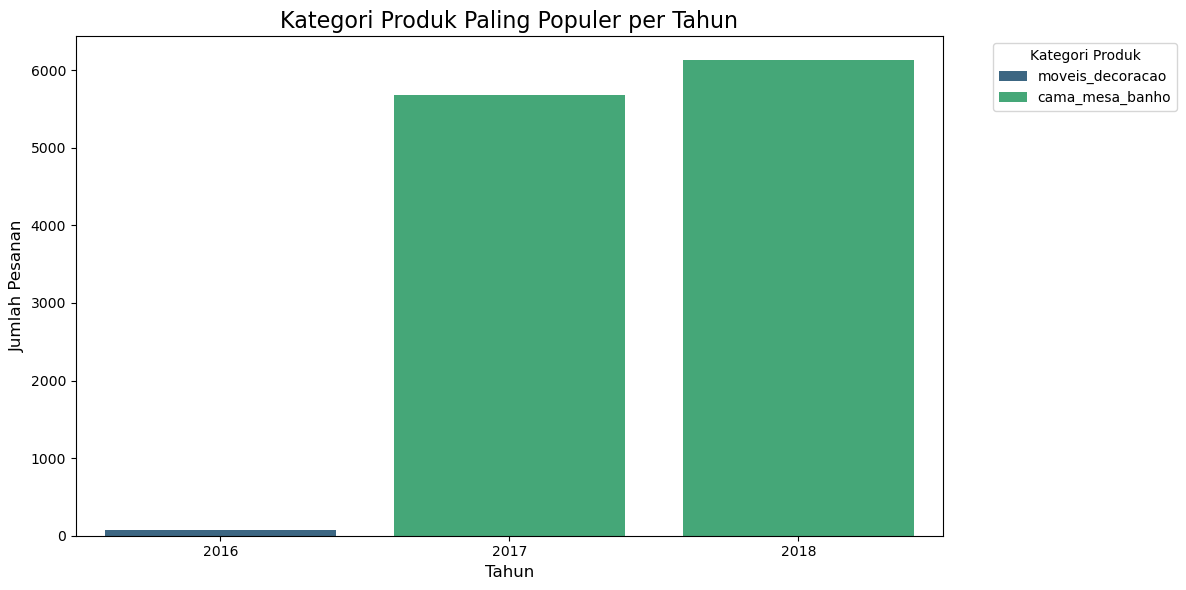

In [337]:
# membuat plot Kategori Produk Paling Populer per Tahun
plt.figure(figsize=(12, 6))
sns.barplot(
    data=kategori_Favorit_per_tahun, #mengambil data dari kategori_Favorit_per_tahun
    x='tahun',
    y='jumlah_pesanan',
    hue='product_category_name', #memberkan warna berbeda setiap kategori
    palette='viridis',
    dodge=False
)
plt.title('Kategori Produk Paling Populer per Tahun', fontsize=16)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Jumlah Pesanan', fontsize=12)
plt.legend(title='Kategori Produk', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('produk populer.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show()

##### Pertumbuhan pesanan untuk setiap wilayah dalam tahun

In [338]:
# Pertumbuhan pesanan tahunan per wilayah
df['order_purchase_year'] = pd.to_datetime(df['order_purchase_timestamp']).dt.year # mengambil Tahun dari Tanggal Pesanan
yearly_growth_per_state = (
    df.groupby(['address_static', 'order_purchase_year'])
      .agg(total_orders=('order_id', 'nunique')) # Agregasi Jumlah Pesanan per Wilayah per Tahun
      .reset_index() 
)
print (yearly_growth_per_state.head (5))

  address_static  order_purchase_year  total_orders
0             AC                 2017            53
1             AC                 2018            27
2             AL                 2016             1
3             AL                 2017           198
4             AL                 2018           198


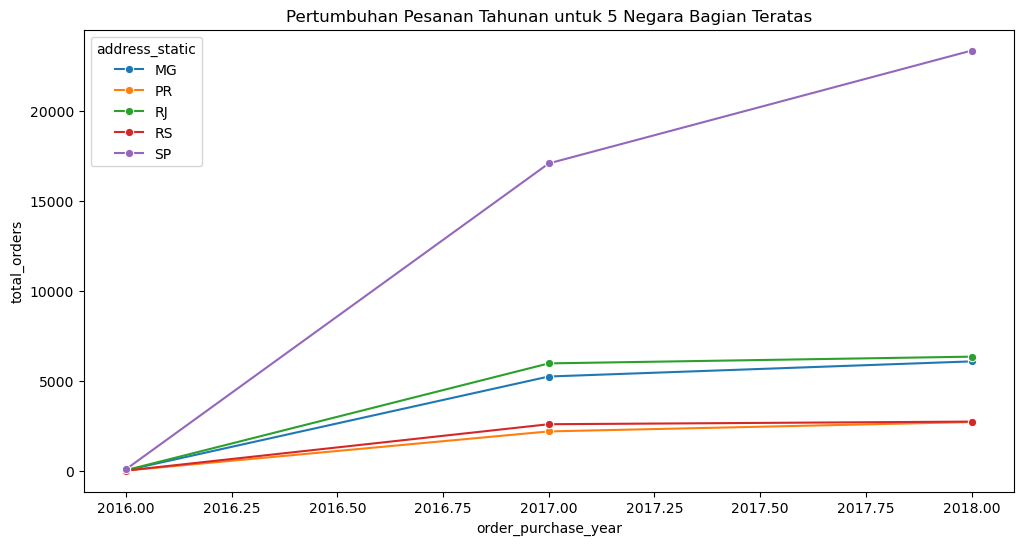

In [339]:
# Pertumbuhan Pesanan Tahunan untuk 5 Negara Bagian Teratas
state_counts = df.groupby('address_static').agg(total_orders=('order_id', 'nunique')).reset_index()
top_states = state_counts.sort_values('total_orders', ascending=False)['address_static'].head(5)

# membuat plot
plt.figure(figsize=(12,6)) # ukuran plot
sns.lineplot(data=yearly_growth_per_state[yearly_growth_per_state['address_static'].isin(top_states)], # Pertumbuhan Pesanan Tahunan untuk 5 Negara Bagian Teratas
             x='order_purchase_year', y='total_orders', hue='address_static', marker='o')
plt.title('Pertumbuhan Pesanan Tahunan untuk 5 Negara Bagian Teratas') # judul plot
plt.savefig('Pertumbuhan Pesanan Tahunan.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show() #menampilkan hasil

## 8. Customer Satisfaction Analysis
#### Mengukur kepuasan pelanggan dan mengidentifikasi faktor yang mempengaruhi.

#### 8.1. Review dan kepuasan pelanggan

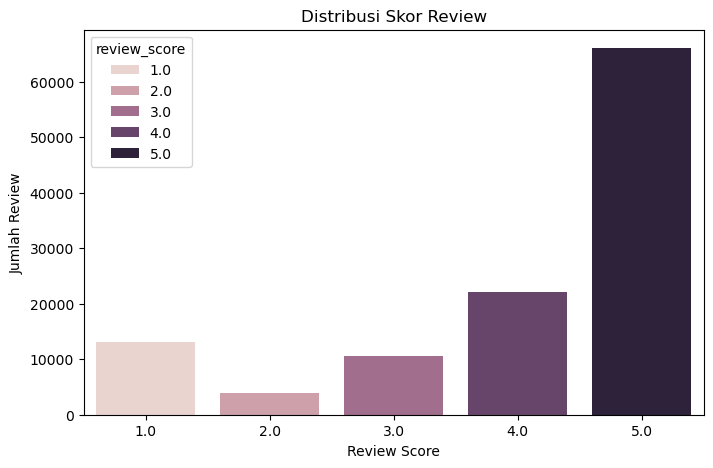

In [340]:
# Distribusi skor review
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='review_score', hue='review_score')
plt.title('Distribusi Skor Review')
plt.xlabel('Review Score')
plt.ylabel('Jumlah Review')
plt.savefig('review skor.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show()

In [341]:
# Review dan kepuasan

#Rata-Rata Skor Review per Pelanggan
review_df = df.groupby('customer_unique_id')['review_score'].mean().reset_index()

# Klasifikasi Tingkat Kepuasan Pelanggan
review_df['kepuasan'] = review_df['review_score'].apply(lambda x: 'puas' if x >= 4 else 'tidak puas')

# menampilkan hasil
print(review_df.head())

                 customer_unique_id  review_score    kepuasan
0  0000366f3b9a7992bf8c76cfdf3221e2           5.0        puas
1  0000b849f77a49e4a4ce2b2a4ca5be3f           4.0        puas
2  0000f46a3911fa3c0805444483337064           3.0  tidak puas
3  0000f6ccb0745a6a4b88665a16c9f078           4.0        puas
4  0004aac84e0df4da2b147fca70cf8255           5.0        puas


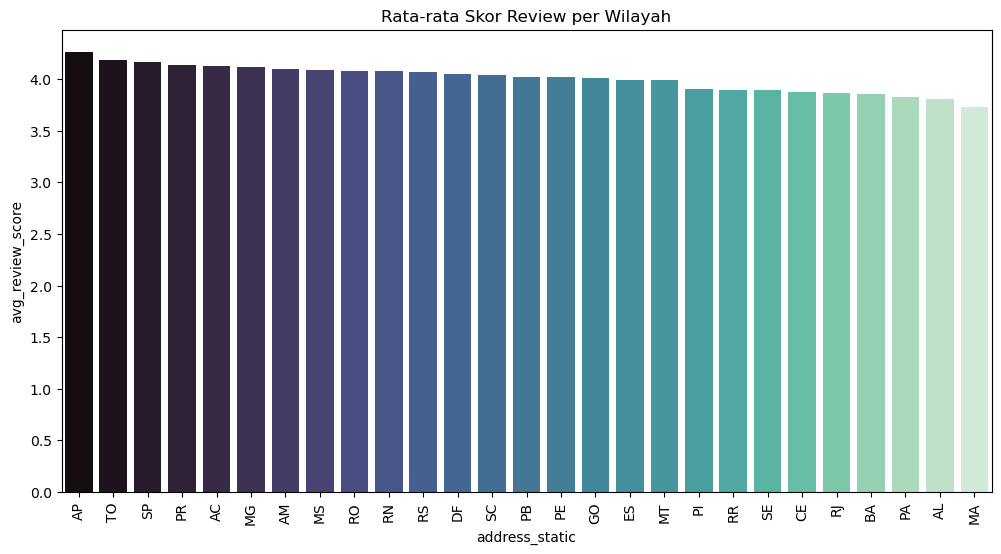

In [342]:
state_review = df.groupby('address_static').agg(
    avg_review_score=('review_score', 'mean'),
    total_reviews=('review_score', 'count')
).reset_index().sort_values('avg_review_score', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=state_review, x='address_static', y='avg_review_score', hue= 'address_static', palette='mako')
plt.title('Rata-rata Skor Review per Wilayah')
plt.xticks(rotation=90)
plt.savefig('avg review wilayah.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show()

####  8.2 judul dan pesan ulasan pelanggan

In [343]:
# Menghitung total review per pelanggan
total_review = review_df.groupby('customer_unique_id').size().reset_index(name='jumlah_review')

# Menggabungkan dengan data frekuensi pesanan
review_ratio = total_review.merge(order_freq, on='customer_unique_id')

# Menghitung rasio review per pesanan
review_ratio['review_per_order'] = review_ratio['jumlah_review'] / review_ratio['total_orders']

# menampilkan hasil
print(review_ratio.head(10))

                 customer_unique_id  jumlah_review  total_orders  \
0  0000366f3b9a7992bf8c76cfdf3221e2              1             1   
1  0000b849f77a49e4a4ce2b2a4ca5be3f              1             1   
2  0000f46a3911fa3c0805444483337064              1             1   
3  0000f6ccb0745a6a4b88665a16c9f078              1             1   
4  0004aac84e0df4da2b147fca70cf8255              1             1   
5  0004bd2a26a76fe21f786e4fbd80607f              1             1   
6  00050ab1314c0e55a6ca13cf7181fecf              1             1   
7  00053a61a98854899e70ed204dd4bafe              1             1   
8  0005e1862207bf6ccc02e4228effd9a0              1             1   
9  0005ef4cd20d2893f0d9fbd94d3c0d97              1             1   

  kategori_frekuensi  review_per_order  
0            sedikit               1.0  
1            sedikit               1.0  
2            sedikit               1.0  
3            sedikit               1.0  
4            sedikit               1.0  
5    

### C. Perbandingan skor review antar kategori produk

In [344]:
avg_review_per_category = (
    df.groupby('product_category_name')
      .agg(avg_review=('review_score', 'mean'))
      .reset_index()
      .sort_values('avg_review', ascending=False)
)

print(avg_review_per_category)


                            product_category_name  avg_review
38                  fashion_roupa_infanto_juvenil    5.000000
18                              cds_dvds_musicais    4.642857
48                              livros_importados    4.525424
49                         livros_interesse_geral    4.491803
65                    portateis_casa_forno_e_cafe    4.453333
..                                            ...         ...
56                              moveis_escritorio    3.548497
66  portateis_cozinha_e_preparadores_de_alimentos    3.428571
43                                fraldas_higiene    3.378378
61                                       pc_gamer    3.333333
68                             seguros_e_servicos    2.500000

[74 rows x 2 columns]


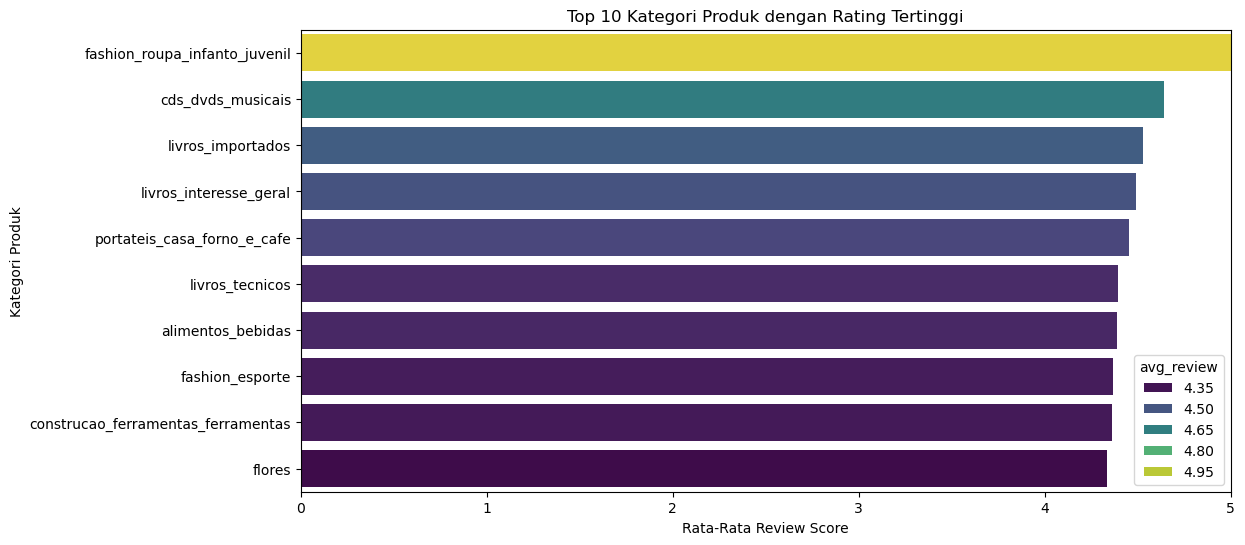

In [364]:
# Top 10 Kategori dengan Rating Tertinggi
plt.figure(figsize=(12, 6))
top_categories = avg_review_per_category.head(10)
sns.barplot(data=top_categories, y='product_category_name', x='avg_review', hue='avg_review',palette='viridis')
plt.title('Top 10 Kategori Produk dengan Rating Tertinggi')
plt.xlabel('Rata-Rata Review Score')
plt.ylabel('Kategori Produk')
plt.xlim(0, 5)  #skala review 1-5
plt.savefig('top 10 review baik.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show()

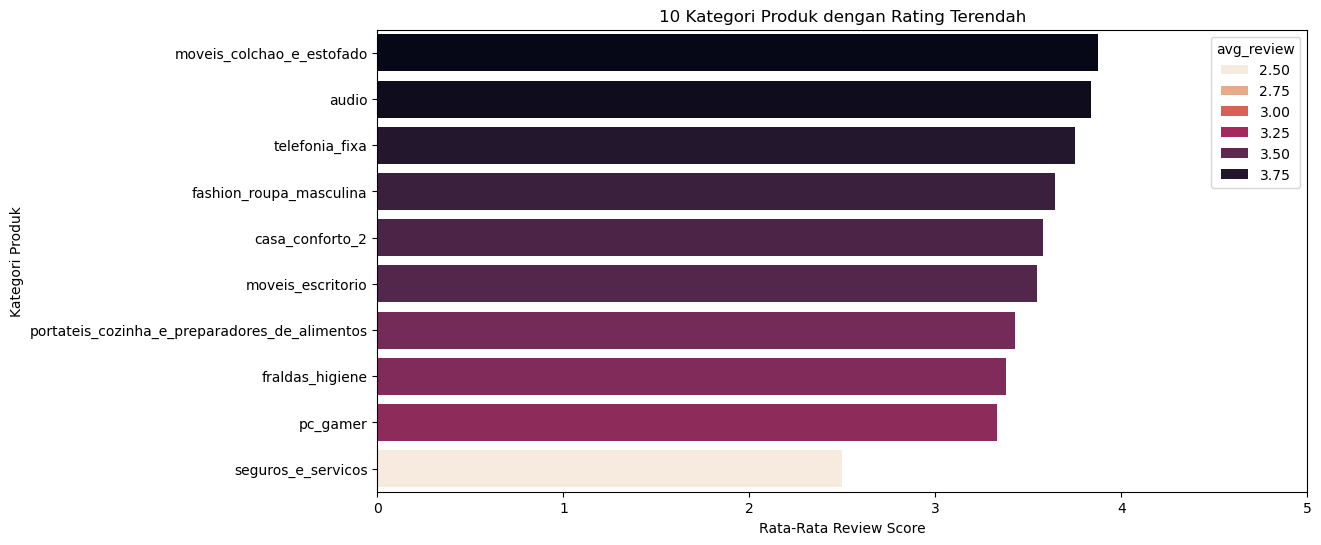

In [365]:
# Bottom 10 Kategori dengan Rating Terendah
plt.figure(figsize=(12, 6))
bottom_categories = avg_review_per_category.tail(10)
sns.barplot(data=bottom_categories, y='product_category_name', x='avg_review',hue='avg_review', palette='rocket_r')
plt.title('10 Kategori Produk dengan Rating Terendah')
plt.xlabel('Rata-Rata Review Score')
plt.ylabel('Kategori Produk')
plt.xlim(0, 5)
plt.savefig('top 10 review buruk.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show()

##### Hasil Analisis
###### - Distribusi skor review menunjukkan apakah mayoritas pelanggan puas (skor 4-5).
###### - Perbandingan antar kategori, produk fashion_roupa_infanto_juvenil sebagai produk dengan rating tertinggi dan seguros_e_servicos sebagai produk dengan rating terendah .
###### - Skor review per wilayah membantu untuk melihat area dengan pengalaman pelanggan terbaik.

##### Rekomnedasi Bisnis
###### 1. Tingkatkan Kualitas di Kategori Skor Rendah
###### - Identifikasi kategori dengan skor review di bawah rata-rata keseluruhan.
###### - Lakukan audit kualitas produk dan vendor pada kategori tersebut.
###### - Perbaiki packaging, pengiriman, atau deskripsi produk agar sesuai ekspektasi.
###### 2. Jadikan Kategori Skor Tinggi Sebagai “Best Seller Booster”
###### - Gunakan kategori dengan skor review tertinggi untuk kampanye promosi atau bundling.
###### - Tampilkan rating positif di halaman produk untuk meningkatkan konversi.
###### 3. Sesuaikan Strategi Pemasaran Berdasarkan Review
###### - Kategori dengan skor sedang tapi volume penjualan tinggi → dorong review positif lewat program insentif atau after-sales follow-up.
###### - Kategori yang sering dibeli pelanggan repeat tapi skornya rendah → prioritas perbaikan, karena berdampak langsung pada retensi.
###### 4. Terapkan Feedback Loop
###### - Gunakan komentar review untuk mendeteksi masalah spesifik (misalnya: “barang rusak saat tiba”, “warna tidak sesuai”).
###### - Sampaikan feedback ini ke supplier atau tim operasional secara terukur dan cepa

## STEP 9: Time Series Analysis

#### 9.1 Analisis trend harian

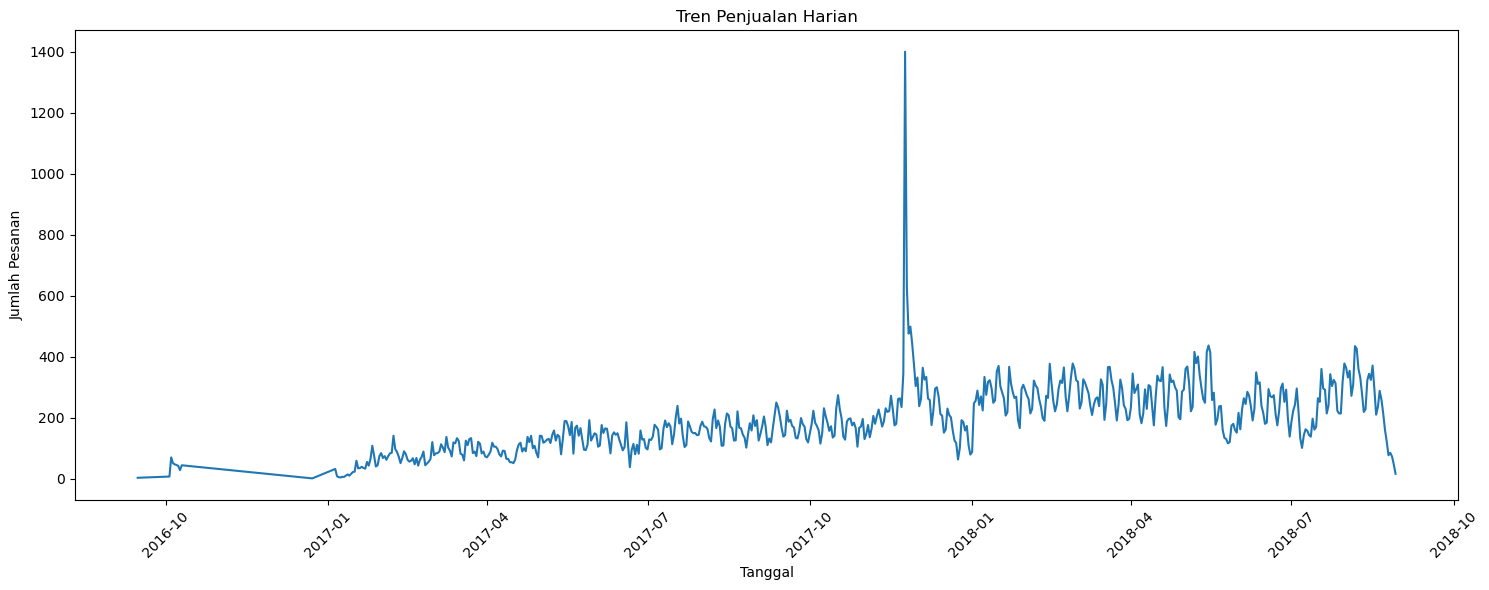

In [345]:
# menghitung julmah oreder harian
order_daily = df.groupby(df['order_purchase_timestamp'].dt.date)['order_id'].count().reset_index(name='jumlah_order')

# Visualisasi Analisis trend harian
plt.figure(figsize=(15,6))
plt.plot(order_daily['order_purchase_timestamp'], order_daily['jumlah_order'])
plt.title('Tren Penjualan Harian')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Pesanan')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('tren penjualan.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show()

In [366]:
# berdasarkan linechart diatas menunjukan bahwa jumlah pesanan cenderung fluktuatif dan stabil.
# namun pada periode akhir tahun 2017 mengalami kenaikan yang sangat signifikan,
# kemungkinan hal tersebut di sebabkan periode akhir tahun sehingga banyak orang belanja.

#### 9.2 analisis trend musiman

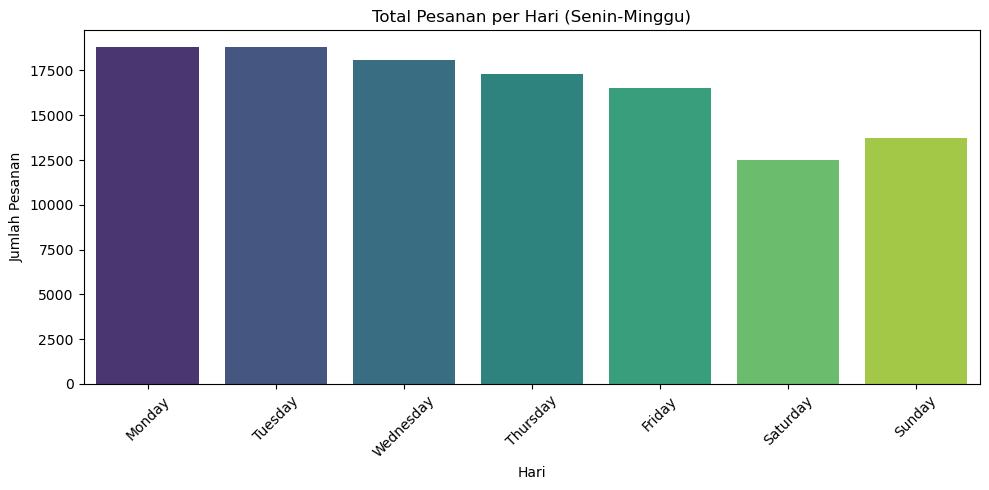

In [346]:
 # Hitung total pesanan per hari (Senin-Minggu)
seasonal_day = df.groupby('nama_hari')['order_id'].count().reset_index(name='total_order')

# mengurutkan hari
hari_urut = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
seasonal_day['nama_hari'] = pd.Categorical(seasonal_day['nama_hari'], categories=hari_urut, ordered=True)
seasonal_day = seasonal_day.sort_values('nama_hari')

# Visualisasi trend musiman 
plt.figure(figsize=(10,5))
sns.barplot(data=seasonal_day, x='nama_hari', y='total_order',hue='nama_hari', palette='viridis', legend=False) #hue='nama_hari': Memberi warna berbeda untuk setiap hari
plt.title('Total Pesanan per Hari (Senin-Minggu)')
plt.ylabel('Jumlah Pesanan')
plt.xlabel('Hari')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('total pesanan per hari.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show()

In [368]:
# berdasarkan chart diatas menunjukan bahwa pelanggan lebih banyak melakukan pembelian di hari biasa, bukan diakhir pekan.
# justru saat di akhir pekan, khususnya di hari sabtu penjualan mengalami penurunan. 
# hal ini bisa di maanfaatkan ketika membuat promo bisa dilakukan di periode hari biasa.

## Analisis CLV (Customer Lifetime Value)
##### Menilai nilai finansial tiap pelanggan selama hubungan mereka dengan perusahaan.

### A. Menghitung CLV (Customer Lifetime Value)

In [347]:
# menghitung total revenue per customer
clv_df = df.groupby('customer_id').agg({
    'payment_value': 'sum',  # total revenue
    'order_id': 'nunique', # jumlah pesanan
    'order_purchase_timestamp': ['min', 'max']
}).reset_index()

# merapikan nama kolom
clv_df.columns = ['customer_id', 'total_revenue', 'total_orders', 'first_order_date', 'last_order_date']

# Komponen CLV
clv_df['avg_order_value'] = clv_df['total_revenue'] / clv_df['total_orders']
clv_df['order_frequency'] = clv_df['total_orders']

# CLV final
clv_df['CLV'] = clv_df['avg_order_value'] * clv_df['order_frequency']

#menampilkan hasil
print(clv_df.head(5))

                        customer_id  total_revenue  total_orders  \
0  00012a2ce6f8dcda20d059ce98491703         114.74             1   
1  000161a058600d5901f007fab4c27140          67.41             1   
2  0001fd6190edaaf884bcaf3d49edf079         195.42             1   
3  0002414f95344307404f0ace7a26f1d5         179.35             1   
4  000379cdec625522490c315e70c7a9fb         107.01             1   

     first_order_date     last_order_date  avg_order_value  order_frequency  \
0 2017-11-14 16:08:26 2017-11-14 16:08:26           114.74                1   
1 2017-07-16 09:40:32 2017-07-16 09:40:32            67.41                1   
2 2017-02-28 11:06:43 2017-02-28 11:06:43           195.42                1   
3 2017-08-16 13:09:20 2017-08-16 13:09:20           179.35                1   
4 2018-04-02 13:42:17 2018-04-02 13:42:17           107.01                1   

      CLV  
0  114.74  
1   67.41  
2  195.42  
3  179.35  
4  107.01  


### B. Distribusi CLV

In [348]:
# CLV final
clv_df['CLV'] = clv_df['avg_order_value'] * clv_df['order_frequency']

# pd.cut adalah Fungsi pandas untuk membagi nilai numerik ke dalam interval tertentu
# Mengelompokkan nilai kontinue menjadi kategori diskrit
clv_df['CLV_segment'] = pd.cut(
    clv_df['CLV'],
    bins=4,
    labels=['Low', 'Medium', 'High', 'VIP'],
    duplicates='drop'
)
# Nilai terendah akan masuk segment 'Low' dan Nilai tertinggi akan masuk segment 'VIP'

print (clv_df.head(5)) #melihat hasil

                        customer_id  total_revenue  total_orders  \
0  00012a2ce6f8dcda20d059ce98491703         114.74             1   
1  000161a058600d5901f007fab4c27140          67.41             1   
2  0001fd6190edaaf884bcaf3d49edf079         195.42             1   
3  0002414f95344307404f0ace7a26f1d5         179.35             1   
4  000379cdec625522490c315e70c7a9fb         107.01             1   

     first_order_date     last_order_date  avg_order_value  order_frequency  \
0 2017-11-14 16:08:26 2017-11-14 16:08:26           114.74                1   
1 2017-07-16 09:40:32 2017-07-16 09:40:32            67.41                1   
2 2017-02-28 11:06:43 2017-02-28 11:06:43           195.42                1   
3 2017-08-16 13:09:20 2017-08-16 13:09:20           179.35                1   
4 2018-04-02 13:42:17 2018-04-02 13:42:17           107.01                1   

      CLV CLV_segment  
0  114.74         Low  
1   67.41         Low  
2  195.42         Low  
3  179.35         Lo

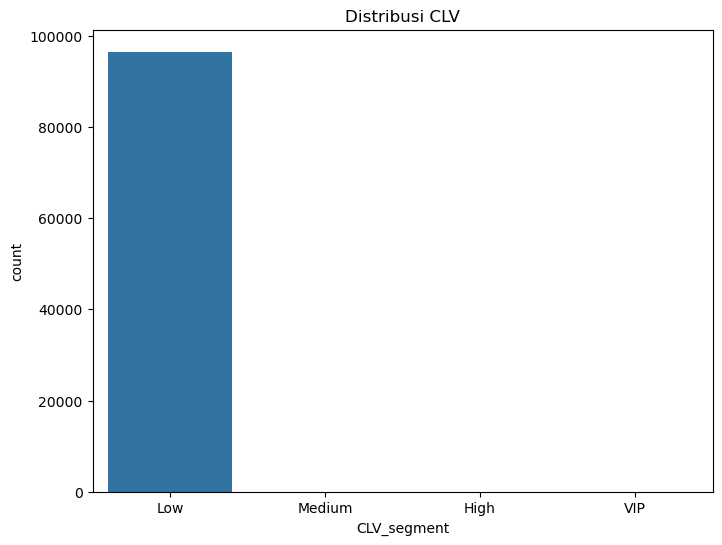

In [351]:
# plot Distribusi CLV
plt.figure(figsize=(8,6)) 
sns.countplot(data=clv_df, x='CLV_segment', order=['Low','Medium','High','VIP']) #Membangi CLV Menjadi 4 segment
plt.title('Distribusi CLV') # Judul Plot
plt.savefig('distribusi clv.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show() #menampilkan plot

In [352]:
# merujuk pada hasil perhitungan, dapat disimpulkan bahwa semua pelanggan hanya melakukan 1 kali transaksi pembelian
# order Frequency = 1 artinya semua pelanggan hanya punya satu pesanan, sehingga retensi (lifespan) = 0 hari. maka jika lifespan = 0, otomatis CLV = 0.

### C. Hubungan Komponen CLV

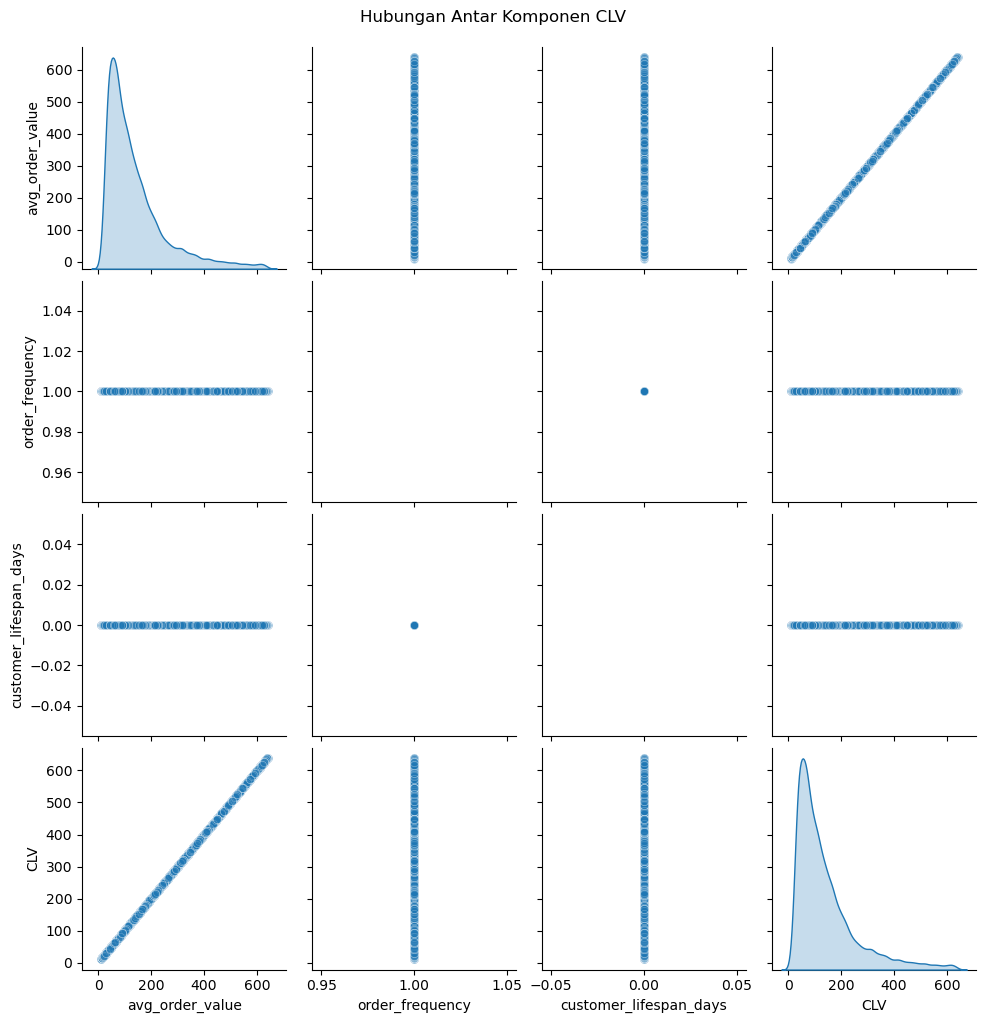

In [353]:
# Filter outlier untuk visualisasi yang lebih jelas
clv_df['customer_lifespan_days'] = (clv_df['last_order_date'] - clv_df['first_order_date']).dt.days # Menghitung Customer Lifespan

clv_filtered = clv_df[clv_df['CLV'] < clv_df['CLV'].quantile(0.95)] # Filter Data CLV untuk Menghilangkan Outlier

sns.pairplot(clv_filtered[['avg_order_value', 'order_frequency', 'customer_lifespan_days', 'CLV']], 
             diag_kind='kde', plot_kws={'alpha':0.5}) # Visualisasi Hubungan Antar Variabel dengan Pairplot
plt.suptitle('Hubungan Antar Komponen CLV', y=1.02) # judul plot
plt.savefig('hub komponen clv.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show()

##### Temuan masalah bisnis
##### 1. Retensi Pelanggan Rendah
###### - Data menunjukkan mayoritas pelanggan hanya melakukan 1 transaksi.
###### - CLV rendah atau bahkan 0 bukan karena nilai order kecil, tetapi karena tidak ada pembelian ulang.
##### 2.CLV Terkunci di Transaksi Pertama
###### - Nilai pelanggan sepenuhnya bergantung pada pembelian pertama, sehingga tidak ada akumulasi pendapatan jangka panjang.
##### 3. Potensi Kehilangan Pendapatan Jangka Panjang
###### - perlu ada upaya untuk pelanggan bisa  untuk membeli 2–3 kali setahun, hal tersebut dapat menuingkatkan CLV tanpa menambah biaya akuisisi baru.

##### Rekomendasi Bisnis
##### 1. Program Retensi & Loyalty
###### - Buat loyalty program (point reward, diskon untuk pembelian berikutnya, voucher toko).
###### - Kirim follow-up pengingat melalui Broadcast Message dengan rekomendasi produk terkait pembelian sebelumnya.
##### 2.Upselling & Cross-selling
###### - Pada pembelian pertama, tawarkan produk pelengkap. bisa dengan menggunakan “bundle deal” untuk meningkatkan basket size.
###### - untuk Pelanggan lama fokus pada penawaran eksklusif untuk repeat order.
###### - Analisis Penyebab Churn dengan mengecek review dan feedback pelanggan.

## 2. Geographic Purchase Trends
##### Memahami perbedaan perilaku belanja antar wilayah.

#### A. Nilai rata-rata order per wilayah

   address_static  avg_order_value
14             PB       284.431603
0              AC       264.792447
3              AP       259.297711
21             RR       245.671304
1              AL       244.332045


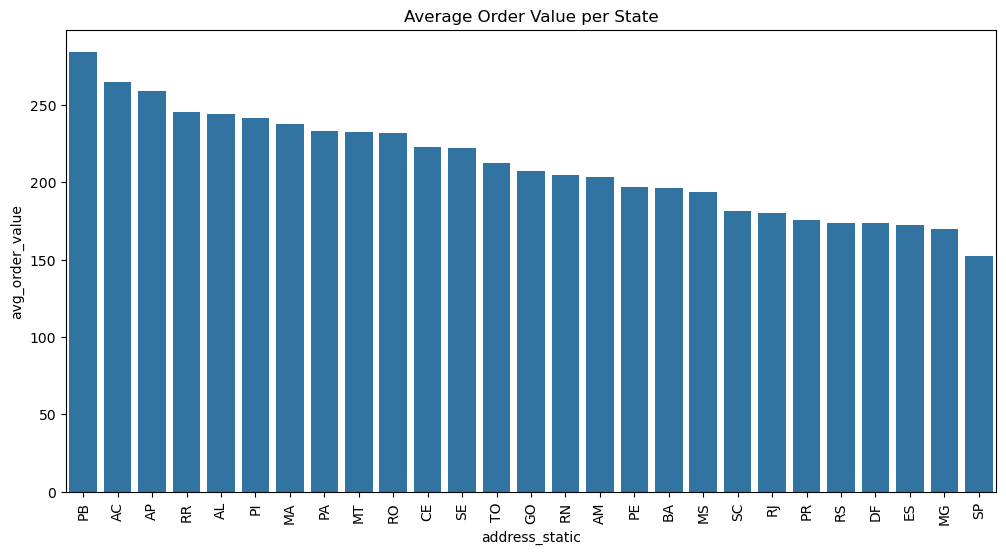

In [354]:
# Menghitung Nilai rata-rata order per wilayah (address_static)
avg_order_value_per_state = df.groupby('address_static').agg(avg_order_value=('payment_value', 'mean')).reset_index()

# mengurutkan dataframe dari terbesar ke terkecil
avg_order_value_per_state = avg_order_value_per_state.sort_values('avg_order_value', ascending=False)

print (avg_order_value_per_state.head(5))

# Average order value per state
plt.figure(figsize=(12,6))
sns.barplot(data=avg_order_value_per_state.sort_values('avg_order_value', ascending=False),
            x='address_static', y='avg_order_value' , order=avg_order_value_per_state['address_static']) # Plot dengan urutan sesuai sorting
plt.title('Average Order Value per State')
plt.xticks(rotation=90)
plt.savefig('avg per state.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show()

###### Dari data jumlah pelanggan per state, terlihat bahwa wilayah dengan total orders tertinggi Kota PB, diikuti kota AC, dikuti kota AP dan seterusnya adalah pasar utama yang harus menjadi fokus distribusi, promosi, dan stok barang.

##### Rekomendasi Bisnis
###### - Untuk daerah yang memiliki jumlah pelanggan banyak , perusahaan bisa mengalokasikan anggaran marketing lebih banyak ke wilayah tersebut.
###### - Daerah dengan nilai rata-rata order tinggi biasanya memiliki daya beli lebih tinggi. Wilayah ini cocok untuk penawaran premium atau bundling produk bernilai besar. Sebaliknya, wilayah dengan nilai rata-rata rendah bisa dioptimalkan dengan promosi diskon kuantitas agar nilai per order naik.
###### - Daerah dengan tren pertumbuhan pesanan tinggi adalah pasar yang berkembang. Perusahaan bisa melakukan ekspansi pemasaran lebih agresif di wilayah ini.
###### - Fokus retensi (loyalty program, membership benefits) di wilayah yang tinggi nilai order nya bisa meningkatkan revenue tanpa biaya akuisisi pelanggan baru.

## 3. Repeat Purchase Patterns
##### Mengukur loyalitas pelanggan

In [355]:
# Hitung frekuensi order per customer
# Mengelompokkan data dalam DataFrame df berdasarkan kolom 'customer_id' dan Menghitung jumlah nilai unik (unique count) dari order_id untuk setiap customer_id
order_frequency = df.groupby('customer_id')['order_id'].nunique().reset_index() 

# merubah nama kolom
order_frequency.rename(columns={'order_id': 'order_frequency'}, inplace=True) 

# menampilkan hasil
print(order_frequency.head(5))

                        customer_id  order_frequency
0  00012a2ce6f8dcda20d059ce98491703                1
1  000161a058600d5901f007fab4c27140                1
2  0001fd6190edaaf884bcaf3d49edf079                1
3  0002414f95344307404f0ace7a26f1d5                1
4  000379cdec625522490c315e70c7a9fb                1


In [356]:
# Filter pelanggan yang order lebih dari 1 kali
repeat_customers = order_frequency[order_frequency['order_frequency'] > 1]
# Lihat hasilnya
print(repeat_customers.head())
print(f"Jumlah pelanggan repeat order: {repeat_customers.shape[0]}")

Empty DataFrame
Columns: [customer_id, order_frequency]
Index: []
Jumlah pelanggan repeat order: 0


In [357]:
# seperti yang kita lihat bahwa, hampir semua pelanggan hanya melakukan 1 kali order/pembelian.
# selanjut nya kita akan mengecek apakah ada pelanggan yang melakukan order lebih dari 1 kali.

#### Distribusi Retention_days (Pembelian pertama dan terakhir)

In [358]:
# pengelompokkan data berdasarkan customer_unique_id (ID unik pelanggan) dan menghitung beberapa metrik.
customer_history = df.groupby('customer_unique_id').agg(
    first_purchase=('order_purchase_timestamp', 'min'), # Tanggal pembelian pertama
    last_purchase=('order_purchase_timestamp', 'max'), # Tanggal pembelian terakhir
).reset_index()

# menghitung selisih waktu antara pembelian terakhir dan pertama
# dt.days Mengonversi selisih waktu ke dalam satuan hari (integer).
customer_history['retention_days'] = (customer_history['last_purchase'] - customer_history['first_purchase']).dt.days 

print(customer_history.head(5)) # menampilkan hasil

                 customer_unique_id      first_purchase       last_purchase  \
0  0000366f3b9a7992bf8c76cfdf3221e2 2018-05-10 10:56:27 2018-05-10 10:56:27   
1  0000b849f77a49e4a4ce2b2a4ca5be3f 2018-05-07 11:11:27 2018-05-07 11:11:27   
2  0000f46a3911fa3c0805444483337064 2017-03-10 21:05:03 2017-03-10 21:05:03   
3  0000f6ccb0745a6a4b88665a16c9f078 2017-10-12 20:29:41 2017-10-12 20:29:41   
4  0004aac84e0df4da2b147fca70cf8255 2017-11-14 19:45:42 2017-11-14 19:45:42   

   retention_days  
0               0  
1               0  
2               0  
3               0  
4               0  


In [359]:
# berdasarkan analisis. semua pelanggan memiliki retention_days dengan nilai nol, hal itu disebabkan karena pembelian pertama dan terakir terjadi di hari yang sama.

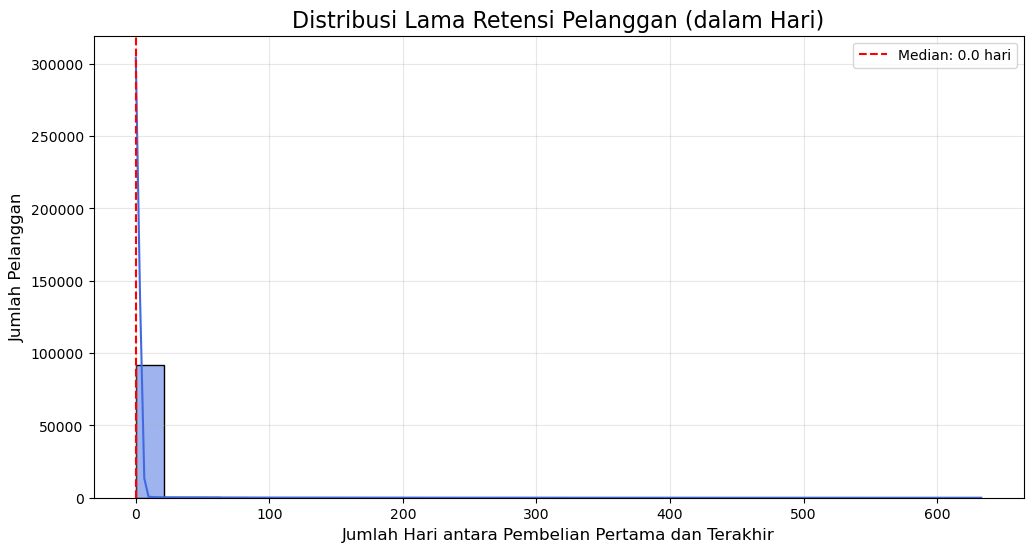

In [360]:
# membuat plot Distribusi Lama Retensi Pelanggan (dalam Hari)
plt.figure(figsize=(12, 6))
sns.histplot(data=customer_history, x='retention_days', bins=30, kde=True, color='royalblue')
plt.title('Distribusi Lama Retensi Pelanggan (dalam Hari)', fontsize=16)
plt.xlabel('Jumlah Hari antara Pembelian Pertama dan Terakhir', fontsize=12)
plt.ylabel('Jumlah Pelanggan', fontsize=12)
plt.axvline(x=customer_history['retention_days'].median(), color='red', linestyle='--', 
            label=f'Median: {customer_history["retention_days"].median()} hari')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('retensi day.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show()

#### Segementasi Pelanggan

In [361]:
# menghitung frekuensi pembelian & total nilai pesanan
customer_stats = df.groupby('customer_id').agg({
    'order_id': 'nunique',
    'payment_value': 'sum'
}).reset_index()

customer_stats.rename(columns={
    'order_id': 'order_frequency',
    'payment_value': 'total_spent'
}, inplace=True)

# Menentukan kategori produk favorit tiap pelanggan
fav_category = (
    df.groupby(['customer_id', 'product_category_name'])
    .size()
    .reset_index(name='count')
    .sort_values(['customer_id', 'count'], ascending=[True, False])
    .drop_duplicates(subset='customer_id', keep='first')
)

# Menggabungkan data
customer_stats = customer_stats.merge(fav_category, on='customer_id', how='left')

# Menambahkan informasi bulan pembelian pertama
first_order_month = df.groupby('customer_id')['order_purchase_timestamp'].min().dt.month
customer_stats = customer_stats.merge(first_order_month.rename('first_order_month'), on='customer_id', how='left')

# Menentukan segmentasi
def segment_customer(row):
    if row['order_frequency'] == 1 and row['total_spent'] < customer_stats['total_spent'].median():
        return 'One-time Low Value'
    elif row['order_frequency'] > 3 and row['total_spent'] >= customer_stats['total_spent'].median():
        return 'Repeat High Value'
    elif row['order_frequency'] == 1 and row['total_spent'] >= customer_stats['total_spent'].median():
        return 'One-time High Value'
    else:
        return 'Repeat Low Value'

customer_stats['segment'] = customer_stats.apply(segment_customer, axis=1)

# Melihat distribusi segmen
print(customer_stats['segment'].value_counts())

segment
One-time High Value    48239
One-time Low Value     48239
Name: count, dtype: int64


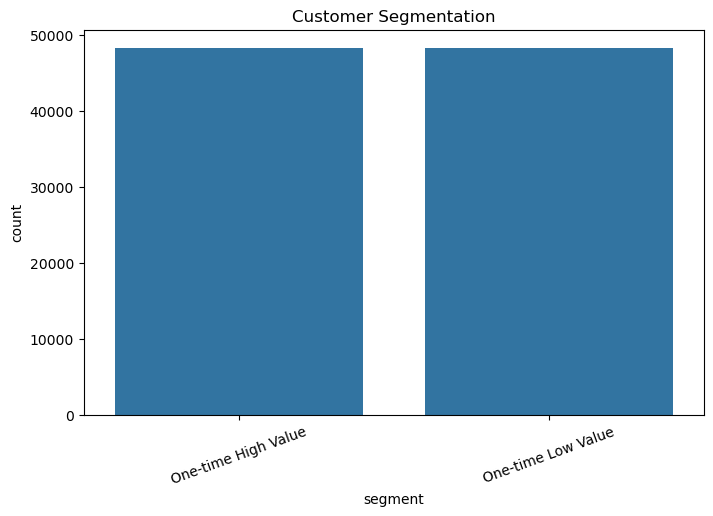

In [268]:
# Memvisualisasi distribusi segmen
plt.figure(figsize=(8,5))
sns.countplot(data=customer_stats, x='segment', order=customer_stats['segment'].value_counts().index)
plt.title('Customer Segmentation')
plt.xticks(rotation=20)
plt.savefig('customer segmentation.png', facecolor='white', transparent=False) # Simpan sebagai PNG
plt.show()

In [369]:
# Pada tabel di atas dapat dilihat bahwa pelanggan hanya masuk kedalam 2 kategori saja dari 4 kategori yang ada. yaitu kategori one-time-high valuedan one-time low value.
# tanpa ada customer yang masuk ke dalam kategori Repeat High Value atau Repeat Low Value